# Evaluate models

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import scipy.stats
from sklearn.metrics import mean_squared_error


# plt.style.use('dark_background')

### Task definition
Specify which task to evaluate: feature selection has been done for `detection_per_mol` and `regression_on_detected` only.

In [20]:
# TASK_TYPE = "detection_per_ion"
# TASK_TYPE = "detection_per_mol"
TASK_TYPE = "regression_on_detected"


EVAL_FEAT_SEL = False

### Define input files and score functions

In [21]:
assert TASK_TYPE in ["detection_per_mol",
                     "detection_per_ion",
                     "regression_on_detected"]

if EVAL_FEAT_SEL:
    assert TASK_TYPE in ["detection_per_mol",
                     "regression_on_detected"]

plots_dir = Path.cwd() / "../plots"
results_dir = Path.cwd() / "../results" / TASK_TYPE



In [22]:
if EVAL_FEAT_SEL:
    filenames = {
        "Fingerprints features": "fingerprints_feat_selection_results.csv"
    }
else:
    filenames = {
        "Fingerprints+Mol features": "results_all_feat.csv",
        "Fingerprings features": "results_fingerprints_feat.csv",
        "Mol features": "results_mol_feat.csv",
        "Baseline (only adduct info)": "results_random_feat.csv",
    }

    # Rename baseline in case we do not give adduct information:
    if "per_mol" in TASK_TYPE:
        filenames["Baseline (no input features)"] =  filenames.pop("Baseline (only adduct info)")


In [23]:
def get_scores(data, task_type="classification"):
    """
    FIXME: generalize for multiple classes
    :param data:
    :param task_type:
    :return:
    """
    if task_type == "classification":
        clf_report = classification_report(data.observed_value, data.prediction, output_dict=True, zero_division=0)
        scores = [clf_report['0']['precision'], clf_report['0']['recall'],
                  clf_report['0']['f1-score'], clf_report['0']['support'],
                  clf_report['1']['precision'], clf_report['1']['recall'],
                  clf_report['1']['f1-score'], clf_report['1']['support'],
                  clf_report['macro avg']['f1-score']]
        if data.observed_value.max() == 0:
            print("no detection!")
    elif task_type == "regression":
        spearman = scipy.stats.spearmanr(data.observed_value, data.prediction)
        pearson = scipy.stats.pearsonr(data.observed_value, data.prediction)
        mse = mean_squared_error(data.observed_value, data.prediction, squared=False)
        mse_std = mse / data['observed_value'].std()
        scores = [spearman[0], spearman[1],
                  pearson[0], pearson[1], mse, mse_std,
                  data[data['observed_value'] != 0].shape[0]]
    else:
        raise ValueError(task_type)
    return scores

### Load predictions and compute scores

In [24]:
main_col_names = ['train_setup', 'model_type']
if EVAL_FEAT_SEL: main_col_names += ['feat_sel_method', 'quantile', 'nb_features']

if "detection" in TASK_TYPE:
    score_cols = ['not_det_precision', 'not_det_recall', 'not_det_f1', 'not_detected',
                  'det_precision', 'det_recall', 'det_f1', 'detected', 'macro_avg_f1_score']
    model_typename = "classifier"
    task_typename = "classification"
elif "regression" in TASK_TYPE:
    score_cols = ["Spearman's R", 'S pval', "Pearson's R", 'P pval', 'RMSE', 'RMSE/std', 'non-zero obs']
    model_typename = "regressor"
    task_typename = "regression"
else:
    raise ValueError(TASK_TYPE)

# Define result dataframes:
model_metrics = pd.DataFrame(columns=['matrix', 'polarity'] + main_col_names + score_cols)
model_metrics_global = pd.DataFrame(columns=main_col_names + score_cols)
models_results = pd.DataFrame()
counter = 0
counter_global = 0

# Loop over training configs:
for train_setup in filenames:
    result_filename = filenames[train_setup]
    loc_models_results = pd.read_csv(results_dir / result_filename, index_col=0)
    loc_models_results = loc_models_results.rename(columns={'Matrix short': 'matrix',
                                                            'Polarity': 'polarity'})

    if loc_models_results.observed_value.dtype == "bool":
        loc_models_results.observed_value = np.where(loc_models_results.observed_value, 1, 0)
    if loc_models_results.prediction.dtype == "bool":
        loc_models_results.prediction = np.where(loc_models_results.prediction, 1, 0)


    # Loop over matrices and model types:
    groupby_cols = ['matrix', 'polarity', model_typename]
    if EVAL_FEAT_SEL: groupby_cols += ['feat_sel_method', 'feat_sel_quantile']
    for groupby_items, rows in loc_models_results.groupby(groupby_cols):
        # Remove undetected from regression score:
        if "regression" in TASK_TYPE:
            rows = rows[rows['observed_value'] != 0]

        # Compute scores:
        matrix, polarity, model_type = groupby_items[:3]
        scores = get_scores(rows, task_type=task_typename)

        # Prepare new row of database with scores:
        new_result_row = [matrix, polarity, train_setup, model_type]
        if EVAL_FEAT_SEL:
            feat_sel_met, quantile = groupby_items[3:]
            new_result_row += [feat_sel_met, round(quantile * 6), rows["nb_features"].drop_duplicates()[0]]
        model_metrics.loc[counter] = new_result_row + scores
        counter += 1

    loc_models_results["train_setup"] = train_setup
    models_results = pd.concat([models_results, loc_models_results])

    # Compute global scores:
    # Loop over model types:
    groupby_cols = [model_typename]
    if EVAL_FEAT_SEL: groupby_cols += ['feat_sel_method', 'feat_sel_quantile']
    for groupby_items, rows in loc_models_results.groupby(groupby_cols):
        # Compute global scores:
        model_type = groupby_items[0] if EVAL_FEAT_SEL else groupby_items
        scores = get_scores(rows, task_type=task_typename)

        # Prepare new row of database with scores:
        new_result_row = [train_setup, model_type]
        if EVAL_FEAT_SEL:
            feat_sel_met, quantile = groupby_items[1:]
            new_result_row += [feat_sel_met,  round(quantile * 6), rows["nb_features"].drop_duplicates()[0]]
        model_metrics_global.loc[counter_global] = new_result_row + scores
        counter_global += 1


Define scores to be plotted:

In [25]:
if "detection" in TASK_TYPE:
    metric = "macro_avg_f1_score"
    count_key = 'detected'
elif "regression" in TASK_TYPE:
    metric = "Spearman's R"
    count_key = 'non-zero obs'
else:
    raise ValueError(TASK_TYPE)



## Plot scores

TODO CHANGE: If `EVAL_FEAT_SEL==True`, nothing will be plotted in this section

### Results for all matrices and model types

regression_on_detected


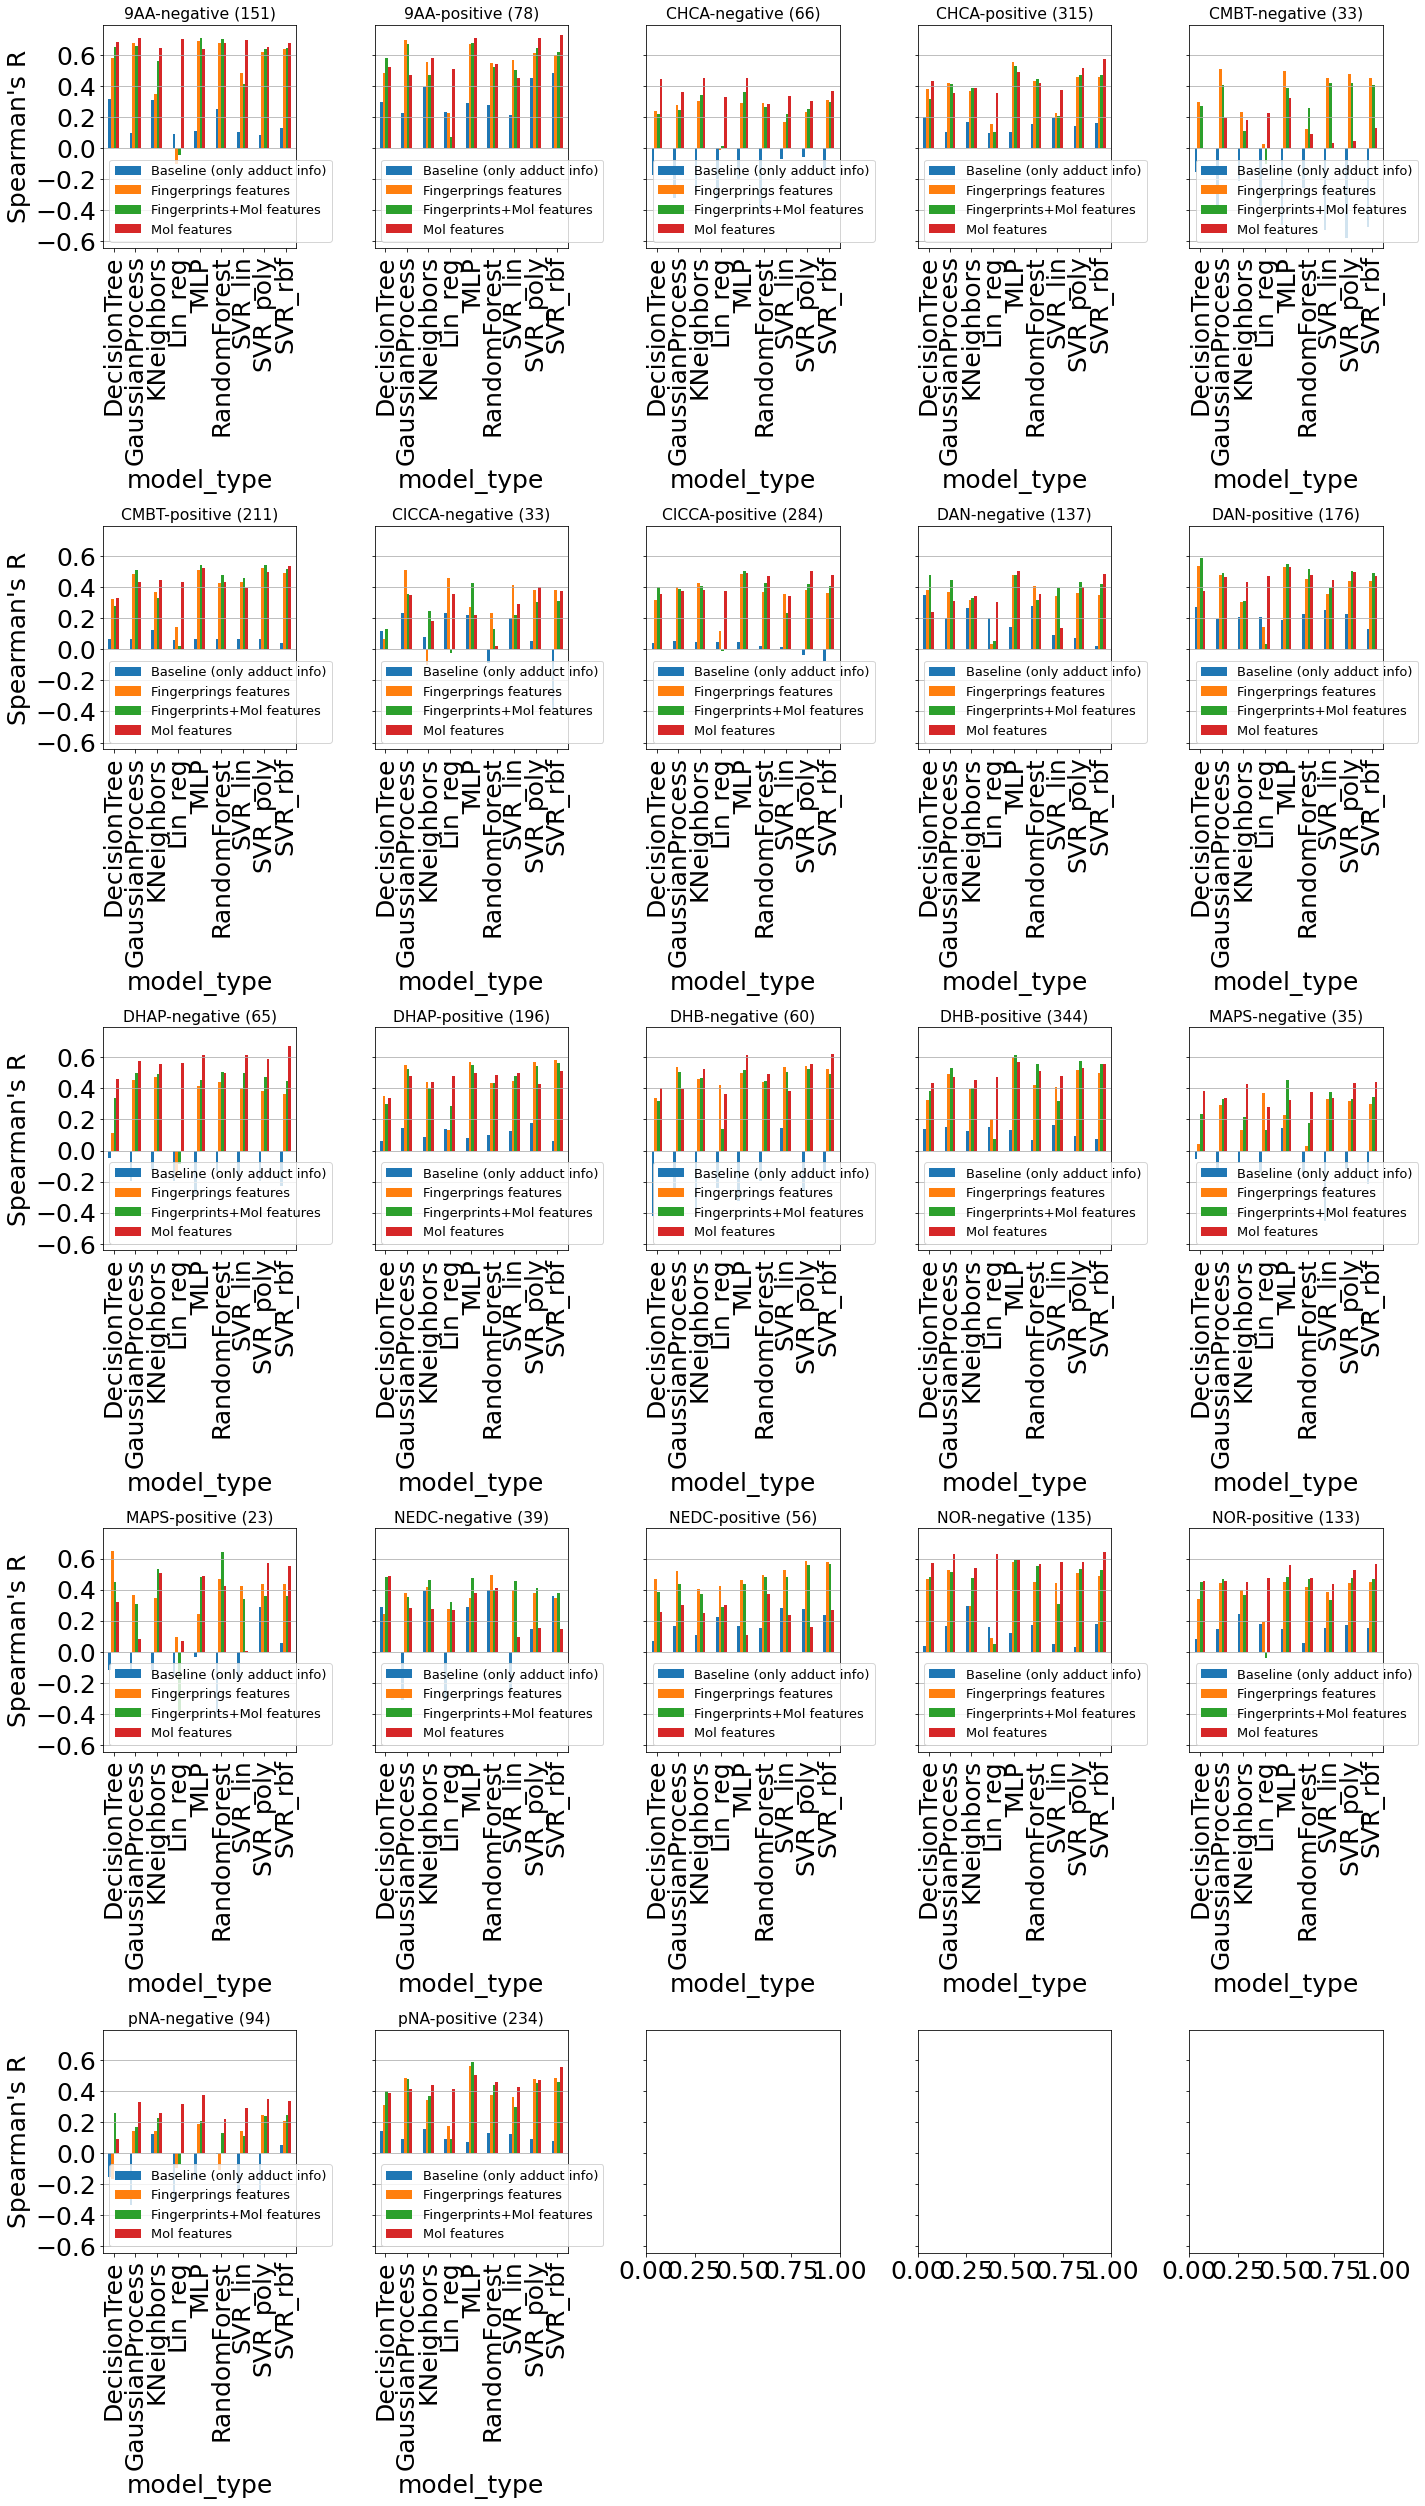

In [26]:
if not EVAL_FEAT_SEL:
    print(TASK_TYPE)
    fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 35))
    plt.rcParams.update({'font.size': 13})
    ax_list = axes.flat

    i = 0
    for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
        nb_obs = rows[count_key].drop_duplicates().values[0]
        rows = rows.set_index(['model_type', "train_setup"], drop = True).sort_values( by = ["train_setup", metric])
        rows = rows.unstack("train_setup")
        rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs})")
        ax_list[i].set_ylabel(metric)
        ax_list[i].grid(axis='y')
        ax_list[i].legend(loc="lower left")
        # if i != 0:
        #     ax_list[i].get_legend().set_visible(False)
        i+=1

    # plt.subplots_adjust(hspace=0.5)
    # fig.suptitle(f"TASK NAME: {TASK_TYPE}")
    plt.tight_layout()
    plt.show()



Global scores across model types:

regression_on_detected


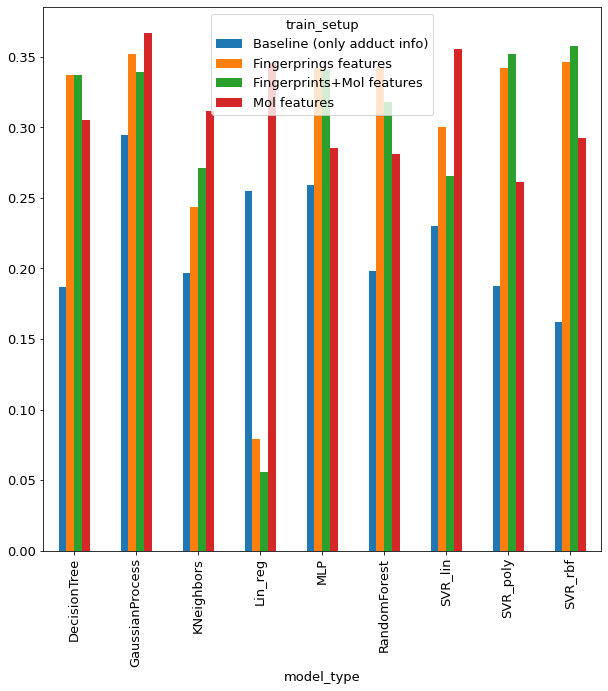

In [27]:
if not EVAL_FEAT_SEL:
    print(TASK_TYPE)
    model_metrics_global.set_index(["model_type", "train_setup"], drop=True)[metric].unstack("train_setup").plot.bar(figsize=(10,10))

### Show scores for a specific model type

In [28]:
selected_model = "MLP"

In [29]:
# Only focus on Random Forest

if not EVAL_FEAT_SEL:
    plotted_model_metrics = model_metrics[model_metrics.model_type == selected_model]
    plotted_model_metrics_global = model_metrics_global[model_metrics_global.model_type == selected_model]

    plotted_model_metrics_global.loc[:,"matrix"] = "GLOBAL"
    plotted_model_metrics_global.loc[:,"polarity"] = "all matrices"

    plotted_model_metrics = pd.concat([plotted_model_metrics, plotted_model_metrics_global],
                                      ignore_index=True)

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_23814/3506651163.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotted_model_metrics_global.loc[:,"matrix"] = "GLOBAL"
/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_23814/3506651163.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotted_model_metrics_global.loc[:,"polarity"] = "all matrices"


regression_on_detected


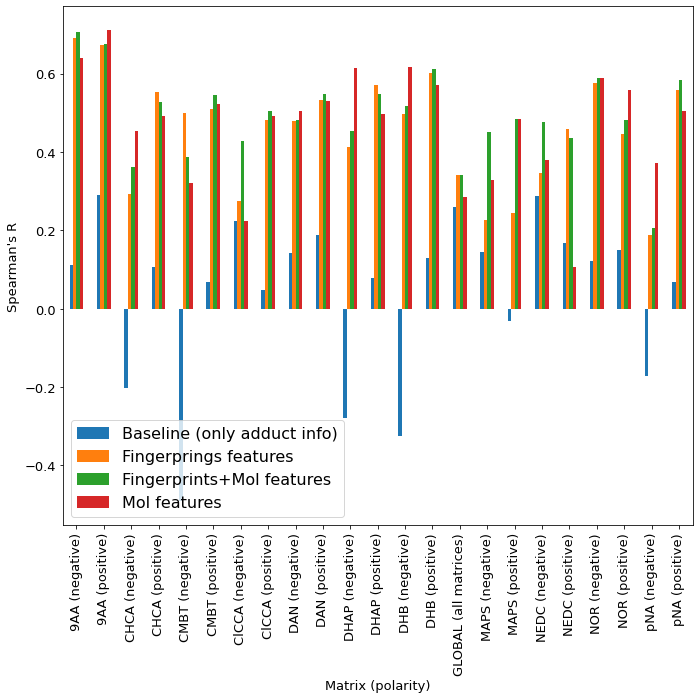

In [30]:
if not EVAL_FEAT_SEL:
    print(TASK_TYPE)
    fig, ax = plt.subplots(ncols=1,nrows=1, sharey=True, figsize= (10, 10))
    plt.rcParams.update({'font.size': 16})
    plotted_model_metrics["Matrix (polarity)"] = plotted_model_metrics["matrix"] + " (" + plotted_model_metrics["polarity"] + ")"

    plotted_model_metrics.set_index(["Matrix (polarity)", "train_setup"], drop=True)[metric].unstack("train_setup").plot.bar(ax=ax)
    ax.legend(loc="lower left")
    ax.set_ylabel(metric)
    plt.tight_layout()
    fig.savefig(plots_dir / f"{selected_model}_scores.pdf")

#### Plot scatter plots in case of regression

Select the training setup on which to focus on:

In [31]:
selected_train_setup = "Fingerprints+Mol features"
# selected_train_setup = "Fingerprings features"
# selected_train_setup = "Mol features"
# selected_train_setup = "Baseline (only adduct info)"


regression_on_detected


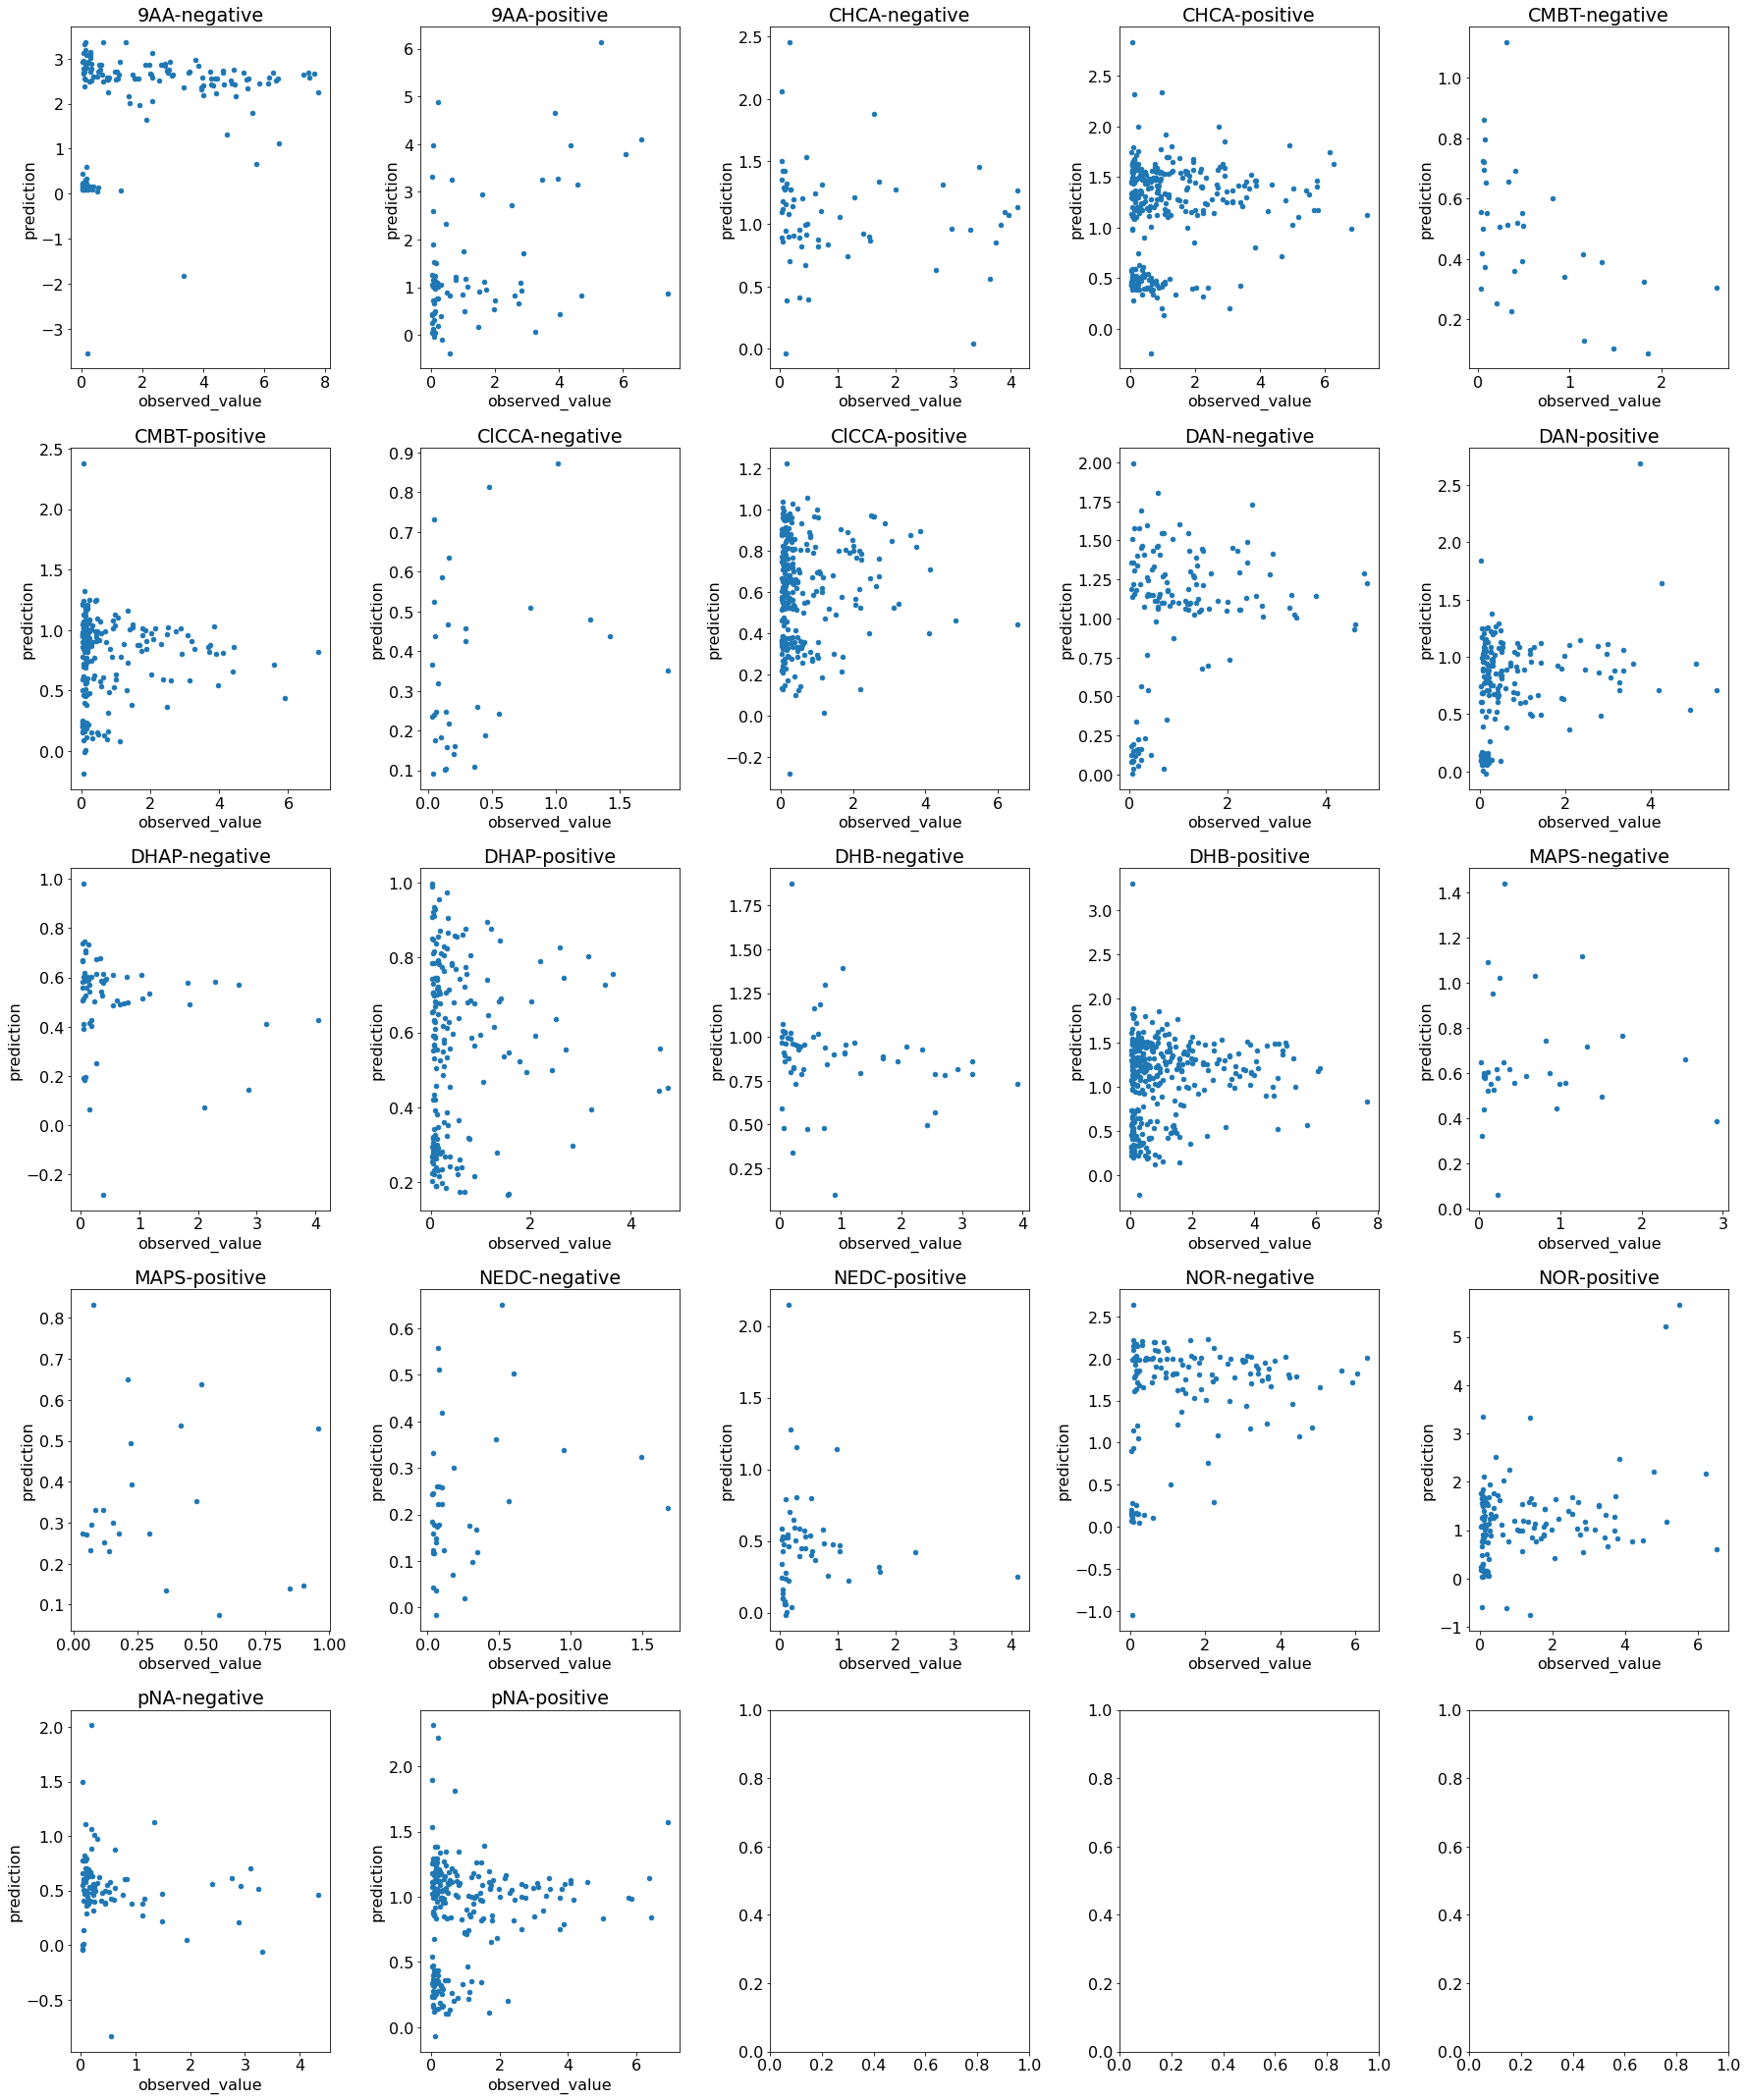

In [32]:
if not EVAL_FEAT_SEL and task_typename == "regression":
    print(TASK_TYPE)
    fig, axes = plt.subplots(ncols=5,nrows=5, figsize= (25, 30))
    ax_list = axes.flat



    i = 0
    for (matrix, polarity), rows in models_results.groupby(['matrix', 'polarity']):
        rows = rows[rows["train_setup"] == train_setup]
        rows = rows[rows["observed_value"] > 0]
        rows[rows[model_typename] == selected_model].plot.scatter(x = 'observed_value', y= 'prediction',
                                                       ax = ax_list[i], title=f"{matrix}-{polarity}")
        i+=1

    plt.tight_layout()
    plt.show()



Only plot for DHB positive:

regression_on_detected


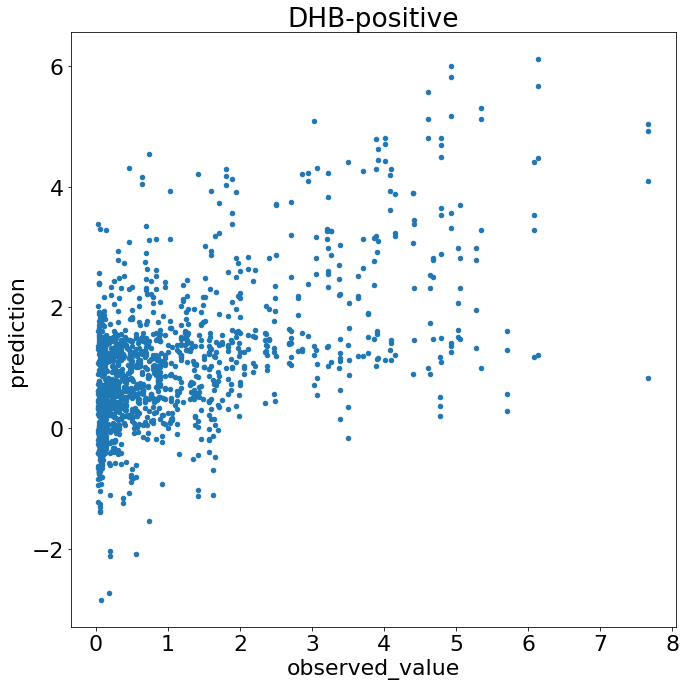

In [33]:
if not EVAL_FEAT_SEL and task_typename == "regression":
    print(TASK_TYPE)
    plt.rcParams.update({'font.size': 22})

    fig, ax = plt.subplots(ncols=1,nrows=1, figsize= (10, 10))
    # ax_list = axes.flat

    i = 0
    rows = models_results[(models_results.matrix == "DHB") & (models_results.polarity == "positive") ]
    rows = rows[rows["observed_value"] > 0]
    rows[rows[model_typename] == selected_model].plot.scatter(x = 'observed_value', y= 'prediction',
                                                       ax = ax, title="DHB-positive")

    # plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.tight_layout()
    plt.show()
    fig.savefig(plots_dir / f"DHB-positive-{selected_model}_scores.png")


## Plot results for feature selection
If `EVAL_FEAT_SEL==False`, nothing will be plotted in this section

In [16]:
feature_sel_method = "kendall"

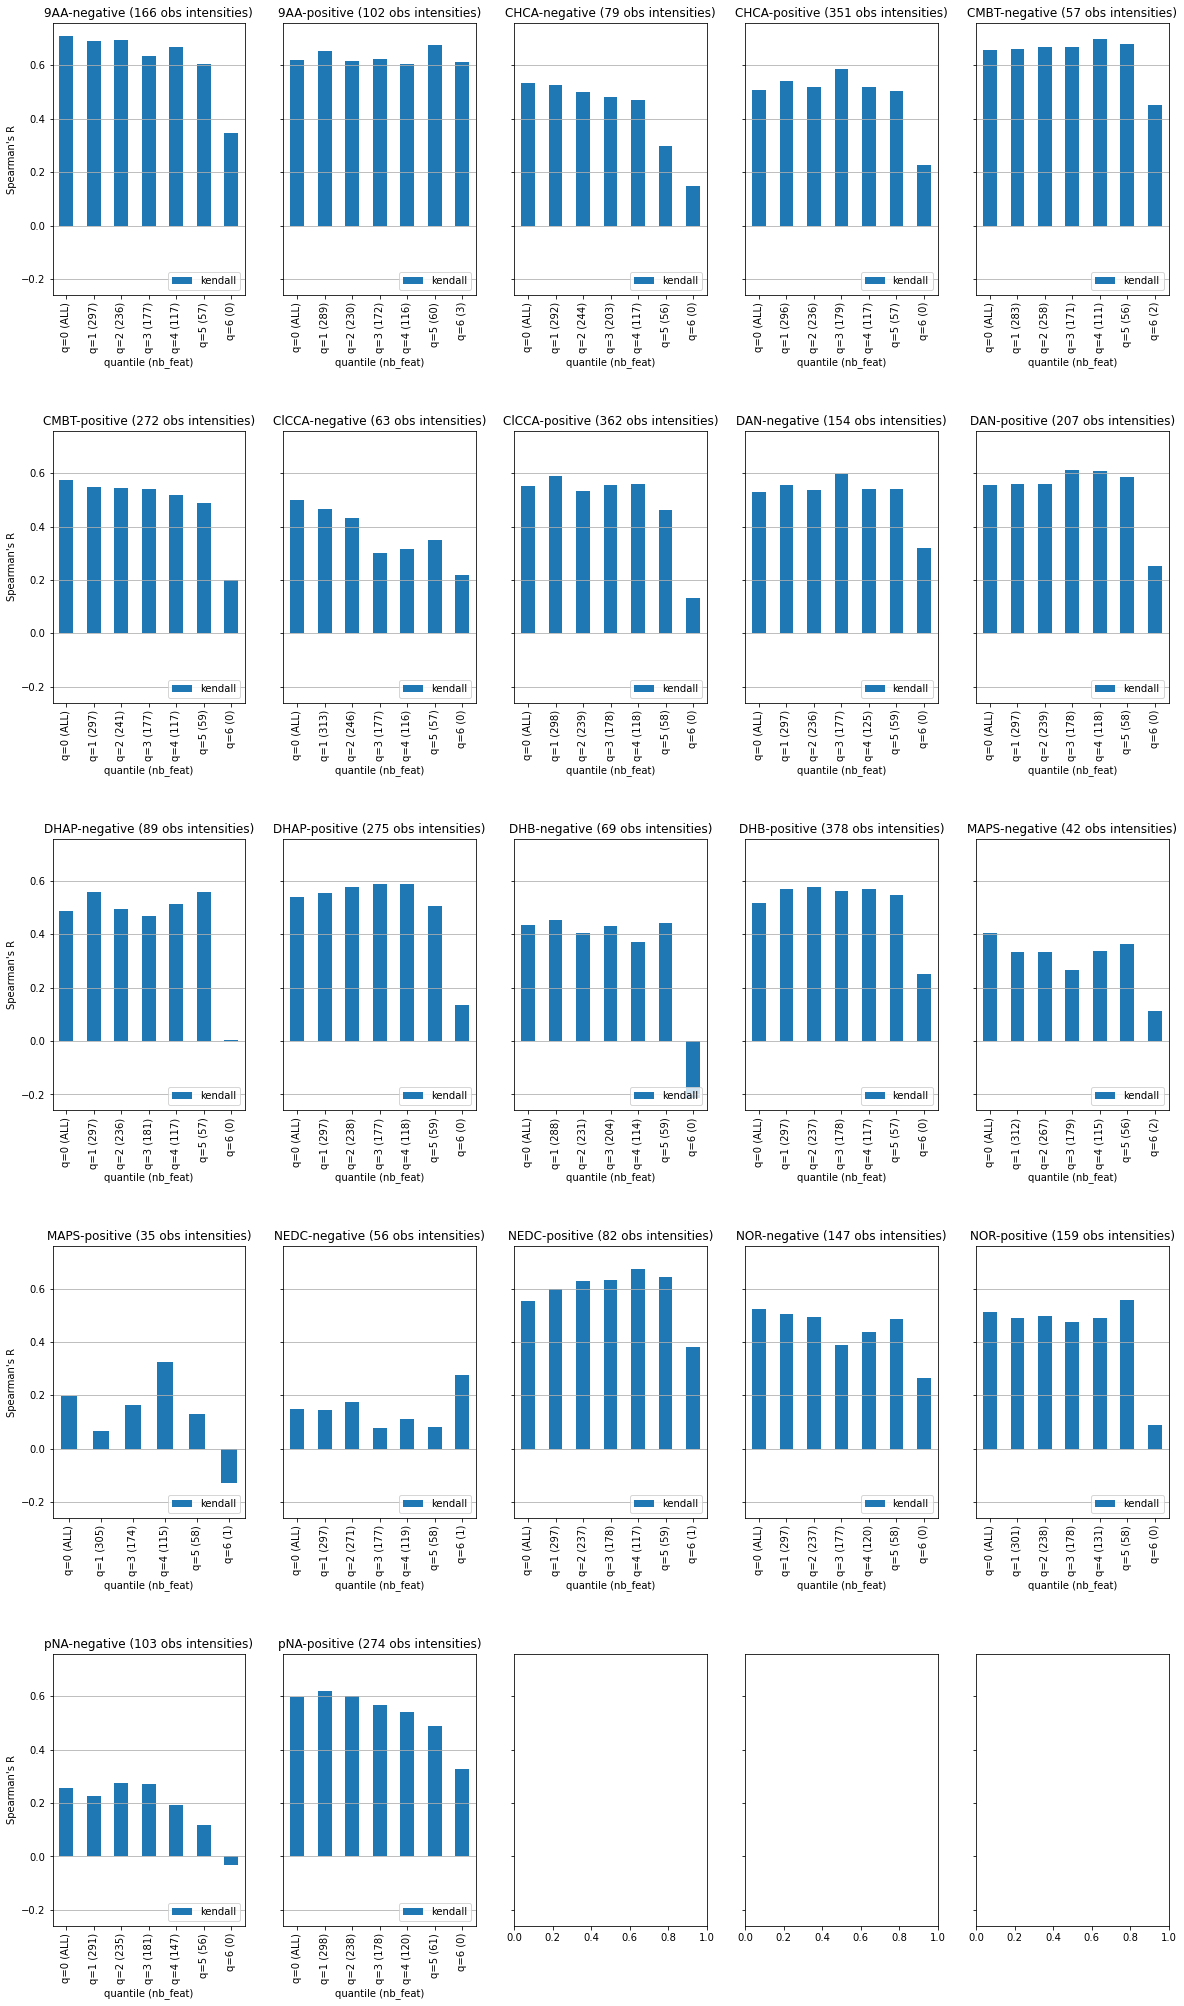

In [17]:
if EVAL_FEAT_SEL:

    plt.rcParams.update({'font.size': 10})
    fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 35))
    ax_list = axes.flat

    plotted_metrics = model_metrics[model_metrics.feat_sel_method == feature_sel_method]
    i = 0
    for (matrix, polarity), rows in plotted_metrics.groupby(['matrix', 'polarity']):
        # nb_obs = rows['non-zero obs'].drop_duplicates().values[0]
        nb_obs = rows[count_key].drop_duplicates().values[0]
        rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
        rows["quantile (nb_feat)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"
        rows = rows.set_index(["quantile (nb_feat)", "feat_sel_method"], drop = True).sort_values( by = ["feat_sel_method", metric])
        rows = rows.unstack("feat_sel_method")
        rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs} obs intensities)")
        ax_list[i].set_ylabel(metric)
        ax_list[i].grid(axis='y')
        # TODO: position legend
        ax_list[i].legend(loc="lower right")
        # if i != 0:
        #     ax_list[i].get_legend().set_visible(False)
        i+=1

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    (plots_dir / "feat_selection").mkdir(exist_ok=True)
    fig.savefig(plots_dir / "feat_selection"/ f"{feature_sel_method}.pdf")


/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_23814/644296846.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_23814/644296846.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows["Quantile (Number of used fingerprint features)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"


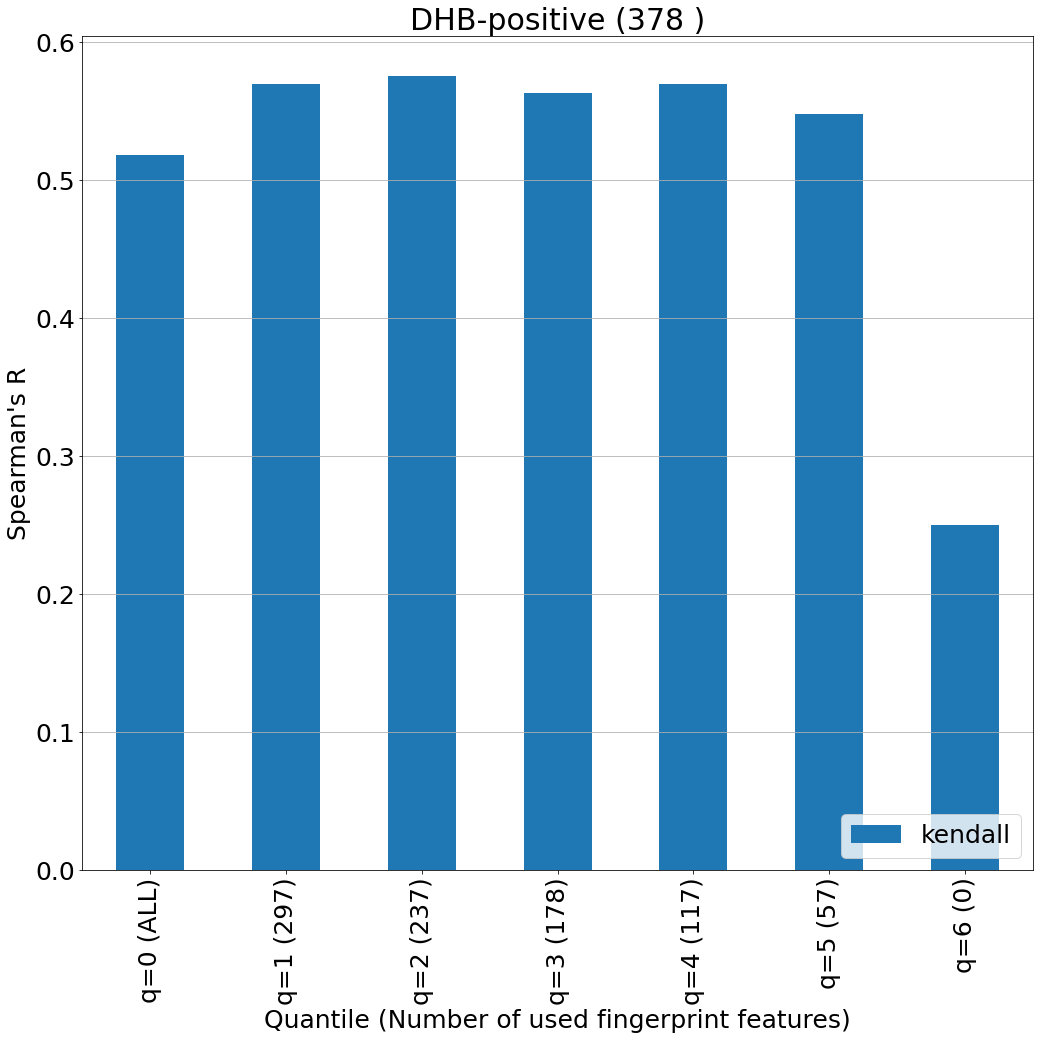

In [18]:
if EVAL_FEAT_SEL:
    plt.rcParams.update({'font.size': 25})
    fig, ax = plt.subplots(ncols=1,nrows=1, sharey=True, figsize= (15, 15))


    rows = model_metrics[(model_metrics.feat_sel_method == feature_sel_method) &
                                    (model_metrics.matrix == "DHB") & (model_metrics.polarity == "positive")]
    if "detection" in TASK_TYPE:
        count_key = 'detected'
    elif "regression" in TASK_TYPE:
        count_key = 'non-zero obs'
    nb_obs = rows[count_key].drop_duplicates().values[0]
    rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
    rows["Quantile (Number of used fingerprint features)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"
    rows = rows.set_index(["Quantile (Number of used fingerprint features)", "feat_sel_method"], drop = True).sort_values( by = ["feat_sel_method", metric])
    rows = rows.unstack("feat_sel_method")
    rows[metric].plot.bar(ax = ax, title=f"DHB-positive ({nb_obs} )")
    ax.set_ylabel(metric)
    ax.grid(axis='y')
    # TODO: position legend
    ax.legend(loc="lower right")
    # if i != 0:
    #     ax_list[i].get_legend().set_visible(False)

    # plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()
    (plots_dir / "feat_selection").mkdir(exist_ok=True)
    fig.savefig(plots_dir / "feat_selection"/ f"{feature_sel_method}-DHB-positive.pdf")

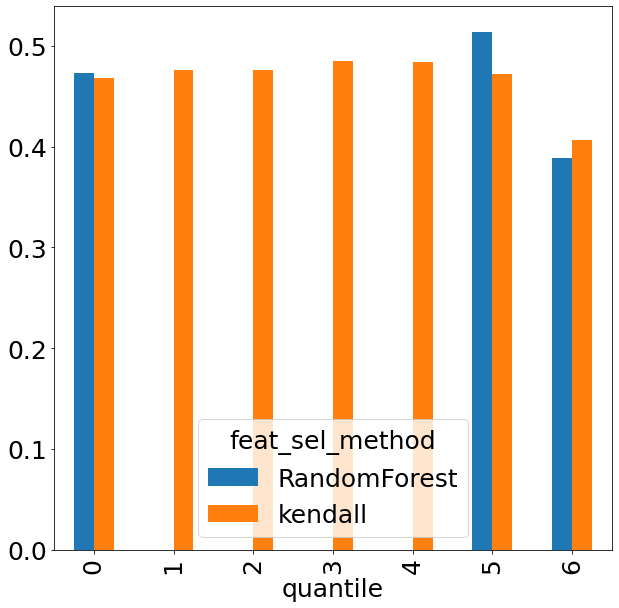

In [19]:
if EVAL_FEAT_SEL:
    model_metrics_global.set_index(['quantile', "feat_sel_method"], drop=True)[metric].unstack("feat_sel_method").plot.bar(figsize=(10,10))